# Building and Optimizing Decision Tree Models for UFC Fight Outcome Prediction


### Data Loading and Feature Selection

- **Load the dataset**
- **Encode the target variable**: Creates a binary column `red_wins`, where `1` represents a win for the red corner and `0` represents a win for the blue corner.
- **Define features and target**: 
  - Extracts relevant features into `X` (input data), such as differences in knockdowns, strikes, height, etc.
  - Assigns the target variable `red_wins` to `y`, which will be used to train the machine learning model.

In [49]:
import os
import pandas as pd
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
from sklearn.impute import SimpleImputer  
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay



# Load the dataset (ensure the file path is correct)
ufc_data_cleaned = pd.read_csv('../data/processed/ufc_data_final.csv')

# Encode target variable: 1 for Red win, 0 for Blue win
ufc_data_cleaned['red_wins'] = (ufc_data_cleaned['winner'] == 'Red').astype(int)


# features = [
#     'kd_diff',                # Difference in knockdowns
#     'sig_str_diff',           # Difference in significant strikes
#     'sig_str_acc_diff',       # Difference in significant strike accuracy
#     'td_diff',                # Difference in takedowns
#     'sub_att_diff',           # Difference in submission attempts
#     'ctrl_sec_diff',          # Difference in control time
#     'height_diff',            # Difference in height
#     'reach_diff',             # Difference in reach
#     'SLpM_total_diff',        # Difference in significant strikes landed per minute
#     'SApM_total_diff',        # Difference in strikes absorbed per minute
#     'sig_str_acc_total_diff', # Difference in overall significant strike accuracy
#     'td_acc_total_diff',      # Difference in takedown accuracy
#     'td_def_total_diff',      # Difference in takedown defense
#     'sub_avg_diff',           # Difference in average submissions per fight
#     'td_avg_diff'             # Difference in average takedowns per fight
# ]
features = [
    'r_age', 'b_age',
    'r_height', 'b_height',
    'r_weight', 'b_weight',
    'r_reach', 'b_reach',
    'r_wins_total', 'b_wins_total',
    'r_losses_total', 'b_losses_total',
    'r_SLpM_total', 'b_SLpM_total',
    'r_SApM_total', 'b_SApM_total',
    'r_sig_str_acc_total', 'b_sig_str_acc_total',
    'r_td_acc_total', 'b_td_acc_total',
    'r_td_def_total', 'b_td_def_total',
    'r_sub_avg', 'b_sub_avg',
    'r_td_avg', 'b_td_avg',
]

X = ufc_data_cleaned[features]
y = ufc_data_cleaned['red_wins']


In [50]:
# Check for missing values
print("\nMissing values in X before imputation:")
print(X.isnull().sum().sum())


Missing values in X before imputation:
0


In [51]:
# Fill missing values with the mean
# imputer = SimpleImputer(strategy='mean')
# X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
# 
# # Verify no missing values
# print("\nMissing values in X after imputation:")
# print(X.isnull().sum().sum())

### Splitting, SMOTE Application, and Model Evaluation

1. **Split the data into training and testing sets (before applying SMOTE):**  
   - The dataset is split into training (`X_train`, `y_train`) and testing (`X_test`, `y_test`) sets using an 80/20 ratio. The random state ensures reproducibility.
   - The sizes of the training and testing sets are printed for verification.

2. **Train a model before applying SMOTE:**  
   - A decision tree classifier with a maximum depth of 5 is trained on the original training data (`X_train`, `y_train`).
   - Predictions are made on the test set (`X_test`), and the model's performance is evaluated using the `classification_report`.

3. **Apply SMOTE to the training data:**  
   - Synthetic Minority Over-sampling Technique (SMOTE) is applied to balance the class distribution in the training set.
   - After applying SMOTE, the new class distribution is printed to verify the balance.

4. **Train a model after applying SMOTE:**  
   - The decision tree classifier is retrained on the resampled data (`X_train_resampled`, `y_train_resampled`).
   - Predictions are again made on the test set, and the updated performance metrics are printed for comparison with the pre-SMOTE model.

In [52]:
# Split the data into training and testing sets (before SMOTE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (5951, 26)
Testing set size: (1488, 26)


In [53]:
# Create a single main model without limiting the depth
clf = DecisionTreeClassifier(random_state=42)  # No max_depth specified

# Train the model on the original data (before SMOTE)
clf.fit(X_train, y_train)
y_pred_before = clf.predict(X_test)

print("\n=== Metrics Before SMOTE ===")
print(classification_report(y_test, y_pred_before, target_names=["Blue Wins", "Red Wins"]))

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nClass Distribution After SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# Retrain the model on balanced data (after SMOTE)
clf.fit(X_train_resampled, y_train_resampled)
y_pred_after = clf.predict(X_test)

print("\n=== Metrics After SMOTE ===")
print(classification_report(y_test, y_pred_after, target_names=["Blue Wins", "Red Wins"]))



=== Metrics Before SMOTE ===
              precision    recall  f1-score   support

   Blue Wins       0.53      0.53      0.53       517
    Red Wins       0.75      0.75      0.75       971

    accuracy                           0.67      1488
   macro avg       0.64      0.64      0.64      1488
weighted avg       0.67      0.67      0.67      1488


Class Distribution After SMOTE:
red_wins
1    3905
0    3905
Name: count, dtype: int64

=== Metrics After SMOTE ===
              precision    recall  f1-score   support

   Blue Wins       0.48      0.51      0.50       517
    Red Wins       0.73      0.71      0.72       971

    accuracy                           0.64      1488
   macro avg       0.61      0.61      0.61      1488
weighted avg       0.65      0.64      0.64      1488



### Weighted Decision Tree Model Training and Evaluation

- **Model creation and training**: A decision tree model is created with class weights `{0: 2, 1: 1}` to give more importance to the minority class (`0: Blue Wins`). The model is trained on the training set (`X_train`, `y_train`).
#### Results Summary

- **Training Accuracy/F1-Score**: Perfect at 1.0, indicating the model fits the training data completely, likely due to overfitting.
- **Testing Accuracy**: 81.3%, showing reasonable generalization to unseen data.
- **Testing F1-Score**: 85.6%, with the model performing better on the majority class (`Red Wins`).
- **Class Imbalance Handling**: Precision and recall for `Blue Wins` are lower, highlighting a slight imbalance in prediction quality between the two classes.

In [54]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Predictions on the training and test sets using the existing model
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Calculate accuracy and F1-Score for training and testing sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Print the metrics
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)
print("Training F1-Score:", train_f1)
print("Testing F1-Score:", test_f1)

# Detailed classification report for the test set
print("\nClassification Report (Test Set):\n", classification_report(y_test, y_test_pred))


Training Accuracy: 0.9968072592841539
Testing Accuracy: 0.6404569892473119
Training F1-Score: 0.9975619145386886
Testing F1-Score: 0.7200418628990057

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.48      0.51      0.50       517
           1       0.73      0.71      0.72       971

    accuracy                           0.64      1488
   macro avg       0.61      0.61      0.61      1488
weighted avg       0.65      0.64      0.64      1488



### Decision Tree Visualization and Saving


In [55]:
# Visualize the decision tree
dot_data = export_graphviz(
    clf,
    out_file=None,
    feature_names=features,
    class_names=['Blue Win', 'Red Win'],
    filled=True,
    rounded=True,
    special_characters=True
)

# Convert to a graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Create the output directory if it doesn't exist
output_dir = 'output_tree_images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the tree image in the specified directory
output_path = os.path.join(output_dir, "decision_tree_visualization.png")
graph.write_png(output_path)

# Display the tree in Jupyter Notebook (optional)
Image(graph.create_png())

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.439095 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.439095 to fit



### Depth-Based Decision Tree Performance Evaluation

- **Purpose**: Evaluates the impact of different `max_depth` values on the performance of a decision tree.

In [56]:
# List of max_depth values to experiment with
max_depth_values = [3, 5, 7, 10, 15, None]  # None = no limit

# Initialize a dictionary to store metrics
metrics = []

for depth in max_depth_values:
    # Create and train the decision tree model with the current max_depth
    clf_pruned = DecisionTreeClassifier(max_depth=depth,class_weight={0: 2, 1: 1},  random_state=42)
    clf_pruned.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_test_pred = clf_pruned.predict(X_test)
    
    # Calculate metrics
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    # Store the results
    metrics.append({
        'max_depth': depth,
        'test_accuracy': test_accuracy,
        'test_f1': test_f1
    })

    # Print metrics for the current depth
    print(f"Max Depth: {depth}")
    print(f"Testing Accuracy: {test_accuracy}")
    print(f"Testing F1-Score: {test_f1}")
    print("-" * 30)




Max Depth: 3
Testing Accuracy: 0.6451612903225806
Testing F1-Score: 0.7033707865168539
------------------------------
Max Depth: 5
Testing Accuracy: 0.6438172043010753
Testing F1-Score: 0.6915017462165308
------------------------------
Max Depth: 7
Testing Accuracy: 0.6579301075268817
Testing F1-Score: 0.7056101792943898
------------------------------
Max Depth: 10
Testing Accuracy: 0.6505376344086021
Testing F1-Score: 0.7048808172531215
------------------------------
Max Depth: 15
Testing Accuracy: 0.6639784946236559
Testing F1-Score: 0.7288503253796096
------------------------------
Max Depth: None
Testing Accuracy: 0.6646505376344086
Testing F1-Score: 0.7473417721518988
------------------------------


### Train and Visualize Decision Tree with max_depth=5

Updated Model Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


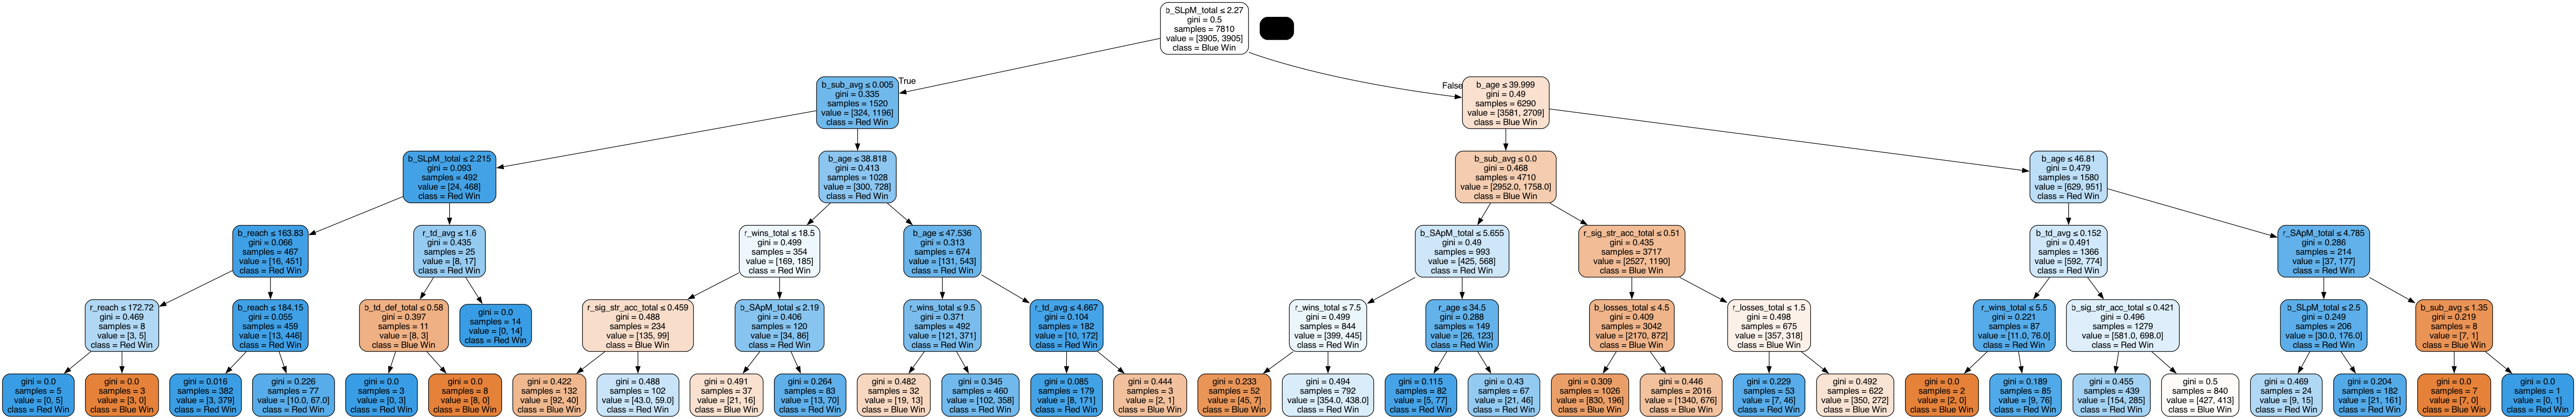

In [57]:
# Set the optimal depth for the main model
clf.set_params(max_depth=5)

# Train the main model on balanced data (after applying SMOTE)
clf.fit(X_train_resampled, y_train_resampled)

# Visualize the decision tree
dot_data = export_graphviz(
    clf,
    out_file=None,
    feature_names=features,
    class_names=['Blue Win', 'Red Win'],
    filled=True,
    rounded=True,
    special_characters=True
)

# Generate the tree graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Create a directory to store the tree image, if it doesn't already exist
output_dir = 'output_tree_images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the tree image to the specified directory
output_path = os.path.join(output_dir, "decision_tree_max_depth_5_smote.png")
graph.write_png(output_path)

# Confirm the model's parameters (for verification)
print("Updated Model Parameters:", clf.get_params())

# Display the tree directly in Jupyter Notebook
Image(graph.create_png())


### Visualizing Feature Importance for Decision Tree (Depth = 5)

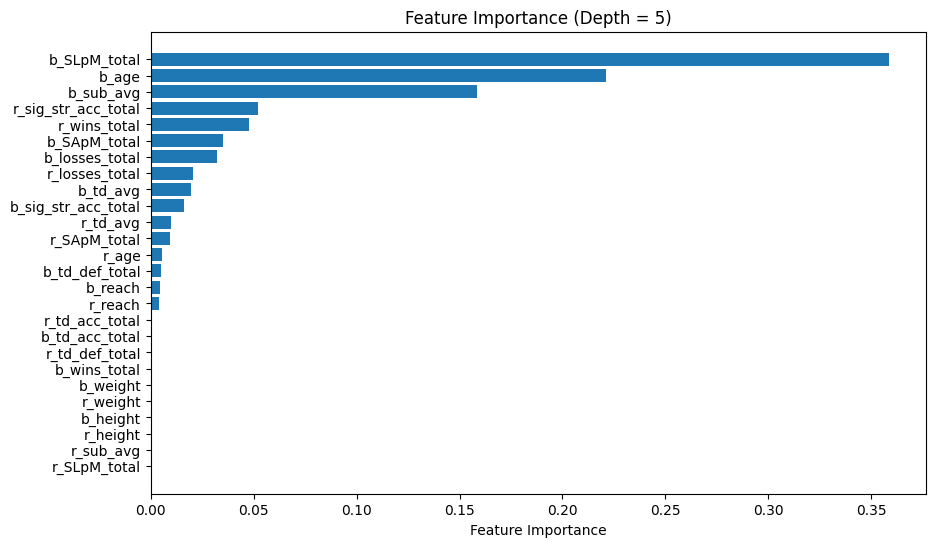

In [58]:
# Feature Importance
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = clf.feature_importances_

# Sort features by importance
sorted_indices = feature_importances.argsort()[::-1]
sorted_features = [features[i] for i in sorted_indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, feature_importances[sorted_indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance (Depth = 5)')
plt.gca().invert_yaxis()
plt.show()


### Compare Feature Importances for Models with Depths 5 and 10

In [59]:
# Model with Depth 5
clf_depth_5 = DecisionTreeClassifier(max_depth=5, random_state=42)
clf_depth_5.fit(X_train_resampled, y_train_resampled)

# Feature importance for Depth 5
importances_5 = pd.Series(clf_depth_5.feature_importances_, index=X.columns)
print("\nFeature Importances for Depth 5:")
print(importances_5.sort_values(ascending=False))

# Model with Depth 10
clf_depth_10 = DecisionTreeClassifier(max_depth=10, random_state=42)
clf_depth_10.fit(X_train_resampled, y_train_resampled)

# Feature importance for Depth 10
importances_10 = pd.Series(clf_depth_10.feature_importances_, index=X.columns)
print("\nFeature Importances for Depth 10:")
print(importances_10.sort_values(ascending=False))



Feature Importances for Depth 5:
b_SLpM_total           0.358542
b_age                  0.221130
b_sub_avg              0.158733
r_sig_str_acc_total    0.052340
r_wins_total           0.047645
b_SApM_total           0.035226
b_losses_total         0.031990
r_losses_total         0.020467
b_td_avg               0.019784
b_sig_str_acc_total    0.016171
r_td_avg               0.009943
r_SApM_total           0.009258
r_age                  0.005311
b_td_def_total         0.004931
b_reach                0.004292
r_reach                0.004237
b_weight               0.000000
r_SLpM_total           0.000000
r_weight               0.000000
b_height               0.000000
r_td_acc_total         0.000000
b_td_acc_total         0.000000
r_td_def_total         0.000000
r_sub_avg              0.000000
r_height               0.000000
b_wins_total           0.000000
dtype: float64

Feature Importances for Depth 10:
b_SLpM_total           0.198600
b_age                  0.109299
b_sub_avg           

In [60]:
# Model with Depth 5
y_test_pred_5 = clf_depth_5.predict(X_test)
print("\nMetrics for Depth 5:")
print(classification_report(y_test, y_test_pred_5))

# Model with Depth 10
y_test_pred_10 = clf_depth_10.predict(X_test)
print("\nMetrics for Depth 10:")
print(classification_report(y_test, y_test_pred_10))



Metrics for Depth 5:
              precision    recall  f1-score   support

           0       0.45      0.69      0.54       517
           1       0.77      0.56      0.65       971

    accuracy                           0.60      1488
   macro avg       0.61      0.62      0.60      1488
weighted avg       0.66      0.60      0.61      1488


Metrics for Depth 10:
              precision    recall  f1-score   support

           0       0.47      0.65      0.54       517
           1       0.76      0.61      0.68       971

    accuracy                           0.62      1488
   macro avg       0.62      0.63      0.61      1488
weighted avg       0.66      0.62      0.63      1488



### Gini vs. Entropy in Decision Trees (Simplified)

- **Gini Criterion**:
  - Focuses on minimizing misclassification.
  - Faster to compute, making it ideal for large datasets.

- **Entropy Criterion**:
  - Measures information gain to choose the best split.
  - Can provide more informative splits but is slightly slower.


In [61]:
from sklearn.metrics import accuracy_score, f1_score

# List of max_depth values to experiment with
max_depth_values = [5, 7, 10]

# Initialize dictionaries to store metrics for Gini and Entropy
metrics_gini = []
metrics_entropy = []

# Loop through each max_depth value
for depth in max_depth_values:
    # Train decision tree with Gini criterion
    clf_gini = DecisionTreeClassifier(max_depth=depth, criterion='gini', random_state=42)
    clf_gini.fit(X_train, y_train)
    y_test_pred_gini = clf_gini.predict(X_test)
    
    # Calculate metrics for Gini
    test_accuracy_gini = accuracy_score(y_test, y_test_pred_gini)
    test_f1_gini = f1_score(y_test, y_test_pred_gini)
    metrics_gini.append({'max_depth': depth, 'accuracy': test_accuracy_gini, 'f1_score': test_f1_gini})
    
    # Train decision tree with Entropy criterion
    clf_entropy = DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=42)
    clf_entropy.fit(X_train, y_train)
    y_test_pred_entropy = clf_entropy.predict(X_test)
    
    # Calculate metrics for Entropy
    test_accuracy_entropy = accuracy_score(y_test, y_test_pred_entropy)
    test_f1_entropy = f1_score(y_test, y_test_pred_entropy)
    metrics_entropy.append({'max_depth': depth, 'accuracy': test_accuracy_entropy, 'f1_score': test_f1_entropy})
    
    # Print the results for the current depth
    print(f"=== Results for max_depth = {depth} ===")
    print("Gini Criterion:")
    print(f"  Testing Accuracy: {test_accuracy_gini:.2f}")
    print(f"  Testing F1-Score: {test_f1_gini:.2f}")
    print("Entropy Criterion:")
    print(f"  Testing Accuracy: {test_accuracy_entropy:.2f}")
    print(f"  Testing F1-Score: {test_f1_entropy:.2f}")
    print("-" * 30)

# Summarize metrics in a DataFrame (optional, for better visualization)
import pandas as pd

df_gini = pd.DataFrame(metrics_gini)
df_entropy = pd.DataFrame(metrics_entropy)

print("\n=== Summary of Gini Metrics ===")
print(df_gini)

print("\n=== Summary of Entropy Metrics ===")
print(df_entropy)

=== Results for max_depth = 5 ===
Gini Criterion:
  Testing Accuracy: 0.70
  Testing F1-Score: 0.80
Entropy Criterion:
  Testing Accuracy: 0.68
  Testing F1-Score: 0.75
------------------------------
=== Results for max_depth = 7 ===
Gini Criterion:
  Testing Accuracy: 0.70
  Testing F1-Score: 0.78
Entropy Criterion:
  Testing Accuracy: 0.69
  Testing F1-Score: 0.76
------------------------------
=== Results for max_depth = 10 ===
Gini Criterion:
  Testing Accuracy: 0.69
  Testing F1-Score: 0.77
Entropy Criterion:
  Testing Accuracy: 0.69
  Testing F1-Score: 0.76
------------------------------

=== Summary of Gini Metrics ===
   max_depth  accuracy  f1_score
0          5  0.699597  0.796726
1          7  0.702957  0.780318
2         10  0.693548  0.772908

=== Summary of Entropy Metrics ===
   max_depth  accuracy  f1_score
0          5  0.678763  0.746285
1          7  0.694220  0.759894
2         10  0.685484  0.761953


In [62]:
# Check the current splitting criterion (e.g., 'gini' or 'entropy')
# This avoids creating a new model and confirms the parameters of the existing one.
print("Current Splitting Criterion:", clf.get_params()['criterion'])


Current Splitting Criterion: gini


### **Hyperparameter Tuning for Decision Tree: GridSearchCV vs RandomizedSearchCV**

This code performs hyperparameter tuning for a decision tree using both **GridSearchCV** (exhaustive search) and **RandomizedSearchCV** (randomized sampling). It identifies the best combination of parameters based on F1-Score and prints the results for comparison.

In [63]:
# Create the decision tree model
tuning_model = DecisionTreeClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 10, 15, None],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'class_weight': [None, {0: 1, 1: 1}, {0: 1, 1: 2}]
}

param_dist = param_grid 

# 1. GridSearchCV
print("\n=== Running GridSearchCV ===")
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

print("Best Parameters (GridSearchCV):", grid_search.best_params_)
print("Best Model (GridSearchCV):", grid_search.best_estimator_)

# 2. RandomizedSearchCV
print("\n=== Running RandomizedSearchCV ===")
random_search = RandomizedSearchCV(clf, param_dist, n_iter=10, scoring='f1', cv=3, random_state=42)
random_search.fit(X_train, y_train)

print("Best Parameters (RandomizedSearchCV):", random_search.best_params_)
print("Best Model (RandomizedSearchCV):", random_search.best_estimator_)



=== Running GridSearchCV ===
Best Parameters (GridSearchCV): {'class_weight': {0: 1, 1: 2}, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best Model (GridSearchCV): DecisionTreeClassifier(class_weight={0: 1, 1: 2}, max_depth=5,
                       min_samples_leaf=10, random_state=42)

=== Running RandomizedSearchCV ===
Best Parameters (RandomizedSearchCV): {'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 3, 'criterion': 'entropy', 'class_weight': {0: 1, 1: 2}}
Best Model (RandomizedSearchCV): DecisionTreeClassifier(class_weight={0: 1, 1: 2}, criterion='entropy',
                       max_depth=3, min_samples_leaf=10, min_samples_split=10,
                       random_state=42)



=== Evaluation of GridSearchCV Best Model ===
              precision    recall  f1-score   support

   Blue Wins       0.71      0.19      0.29       517
    Red Wins       0.69      0.96      0.80       971

    accuracy                           0.69      1488
   macro avg       0.70      0.57      0.55      1488
weighted avg       0.69      0.69      0.63      1488


=== Predicted Class Distribution (GridSearchCV) ===
Blue Wins Predicted: 9.14%
Red Wins Predicted: 90.86%


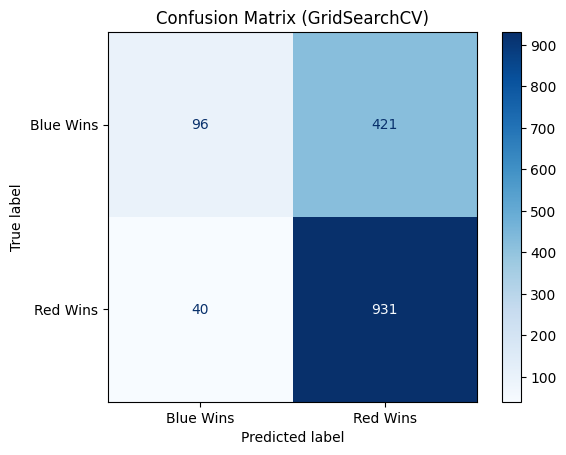


=== Evaluation of RandomizedSearchCV Best Model ===
              precision    recall  f1-score   support

   Blue Wins       0.75      0.01      0.01       517
    Red Wins       0.65      1.00      0.79       971

    accuracy                           0.65      1488
   macro avg       0.70      0.50      0.40      1488
weighted avg       0.69      0.65      0.52      1488


=== Predicted Class Distribution (RandomizedSearchCV) ===
Blue Wins Predicted: 0.27%
Red Wins Predicted: 99.73%


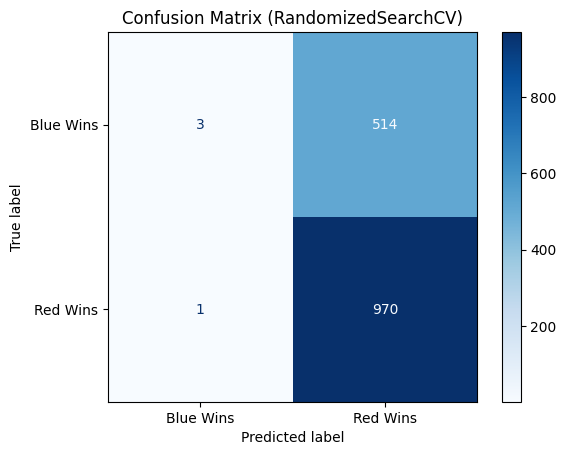

In [64]:
# Import metrics
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# Evaluate the best GridSearchCV model
best_model_grid = grid_search.best_estimator_
y_pred_grid = best_model_grid.predict(X_test)

# Evaluate metrics for GridSearchCV model
print("\n=== Evaluation of GridSearchCV Best Model ===")
print(classification_report(y_test, y_pred_grid, target_names=["Blue Wins", "Red Wins"]))

# Predicted class distribution
predicted_counts_grid = pd.Series(y_pred_grid).value_counts(normalize=True) * 100
print("\n=== Predicted Class Distribution (GridSearchCV) ===")
print(f"Blue Wins Predicted: {predicted_counts_grid[0]:.2f}%")
print(f"Red Wins Predicted: {predicted_counts_grid[1]:.2f}%")

# Confusion matrix
conf_matrix_grid = confusion_matrix(y_test, y_pred_grid)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_grid, display_labels=["Blue Wins", "Red Wins"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (GridSearchCV)")
plt.show()

# Evaluate the best RandomizedSearchCV model
best_model_random = random_search.best_estimator_
y_pred_random = best_model_random.predict(X_test)

# Evaluate metrics for RandomizedSearchCV model
print("\n=== Evaluation of RandomizedSearchCV Best Model ===")
print(classification_report(y_test, y_pred_random, target_names=["Blue Wins", "Red Wins"]))

# Predicted class distribution
predicted_counts_random = pd.Series(y_pred_random).value_counts(normalize=True) * 100
print("\n=== Predicted Class Distribution (RandomizedSearchCV) ===")
print(f"Blue Wins Predicted: {predicted_counts_random[0]:.2f}%")
print(f"Red Wins Predicted: {predicted_counts_random[1]:.2f}%")

# Confusion matrix
conf_matrix_random = confusion_matrix(y_test, y_pred_random)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_random, display_labels=["Blue Wins", "Red Wins"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (RandomizedSearchCV)")
plt.show()

### 10-Fold Cross-Validation for Model Performance Evaluation

- cv=10: Divides the dataset into 10 parts for cross-validation.
- scoring='f1': Evaluates the model based on the F1-Score, which balances precision and recall.

In [65]:
from sklearn.model_selection import cross_val_score

# Perform 10-fold cross-validation
cv_scores = cross_val_score(clf, X, y, cv=10, scoring='f1')

# Output the results
print("Cross-Validation F1-Score (mean):", cv_scores.mean())
print("Cross-Validation F1-Score (all folds):", cv_scores)


Cross-Validation F1-Score (mean): 0.7276632418827812
Cross-Validation F1-Score (all folds): [0.60391198 0.73900293 0.60963855 0.66902238 0.73951435 0.81211042
 0.78491859 0.7883959  0.81481481 0.71530249]


In [66]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.validation import check_is_fitted

# Check if the model is fitted
try:
    check_is_fitted(clf)
    print("The model is fitted and ready for evaluation.")
except:
    print("The model is not fitted yet. Please train the model first.")
    raise

# Metrics on training data
y_train_pred = clf.predict(X_train)
print("\n=== Metrics on Training Data ===")
print(classification_report(y_train, y_train_pred, target_names=["Blue Wins", "Red Wins"]))

# Metrics on test data
y_test_pred = clf.predict(X_test)
print("\n=== Metrics on Test Data ===")
print(classification_report(y_test, y_test_pred, target_names=["Blue Wins", "Red Wins"]))

# Accuracy and F1-Score for test data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test F1-Score: {test_f1:.2f}")

# Predicted percentages
predicted_counts = pd.Series(y_test_pred).value_counts()
predicted_percentages = (predicted_counts / len(y_test_pred)) * 100
print("\n=== Predicted Class Distribution ===")
print(f"Blue Wins: {predicted_percentages[0]:.2f}%")
print(f"Red Wins: {predicted_percentages[1]:.2f}%")

# # Confusion matrix
# conf_matrix = confusion_matrix(y_test, y_test_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Blue Wins", "Red Wins"])
# disp.plot(cmap="Blues")
# plt.title("Confusion Matrix")
# plt.show()

# # Feature importances
# feature_importances = pd.Series(clf.feature_importances_, index=X.columns)
# print("\nFeature Importances:")
# print(feature_importances.sort_values(ascending=False))

# # Visualize feature importances
# feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6), title='Feature Importances')
# plt.xlabel("Features")
# plt.ylabel("Importance")
# plt.show()

# Final metrics summary
print("\n=== Final Metrics Summary ===")
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Training F1-Score: {f1_score(y_train, y_train_pred):.2f}")
print(f"Test F1-Score: {test_f1:.2f}")


The model is fitted and ready for evaluation.

=== Metrics on Training Data ===
              precision    recall  f1-score   support

   Blue Wins       0.48      0.73      0.58      2046
    Red Wins       0.81      0.58      0.68      3905

    accuracy                           0.63      5951
   macro avg       0.64      0.66      0.63      5951
weighted avg       0.69      0.63      0.64      5951


=== Metrics on Test Data ===
              precision    recall  f1-score   support

   Blue Wins       0.45      0.69      0.54       517
    Red Wins       0.77      0.56      0.65       971

    accuracy                           0.60      1488
   macro avg       0.61      0.62      0.60      1488
weighted avg       0.66      0.60      0.61      1488

Test Accuracy: 0.60
Test F1-Score: 0.65

=== Predicted Class Distribution ===
Blue Wins: 52.82%
Red Wins: 47.18%

=== Final Metrics Summary ===
Training Accuracy: 0.63
Test Accuracy: 0.60
Training F1-Score: 0.68
Test F1-Score: 0.65


In [67]:
# Предполагается, что модель clf уже обучена
print("=== Model Information ===")
print(f"Criterion: {clf.get_params()['criterion']}")
print(f"Max Depth (specified): {clf.get_params()['max_depth']}")
print(f"Actual Depth: {clf.get_depth()}")
print(f"Number of Nodes: {clf.tree_.node_count}")
print(f"Number of Classes: {len(clf.classes_)}")



correlation = X[['r_SLpM_total', 'b_SLpM_total']].corr()
print(correlation)
print("F1-Score for each fold:", cv_scores)
print("Standard deviation:", cv_scores.std())
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

# Вывод используемых признаков (если поддерживается)
# Вывод количества признаков
print(f"Number of features (columns) in X: {X.shape[1]}")
print(f"Feature names: {features}")
print("Column names:")
print(ufc_data_cleaned.columns.to_list())


print(pd.Series(y_train_resampled).value_counts())



=== Model Information ===
Criterion: gini
Max Depth (specified): 5
Actual Depth: 5
Number of Nodes: 61
Number of Classes: 2
              r_SLpM_total  b_SLpM_total
r_SLpM_total      1.000000      0.353854
b_SLpM_total      0.353854      1.000000
F1-Score for each fold: [0.60391198 0.73900293 0.60963855 0.66902238 0.73951435 0.81211042
 0.78491859 0.7883959  0.81481481 0.71530249]
Standard deviation: 0.07402576030471958
red_wins
1    0.656192
0    0.343808
Name: proportion, dtype: float64
red_wins
1    0.652554
0    0.347446
Name: proportion, dtype: float64
Number of features (columns) in X: 26
Feature names: ['r_age', 'b_age', 'r_height', 'b_height', 'r_weight', 'b_weight', 'r_reach', 'b_reach', 'r_wins_total', 'b_wins_total', 'r_losses_total', 'b_losses_total', 'r_SLpM_total', 'b_SLpM_total', 'r_SApM_total', 'b_SApM_total', 'r_sig_str_acc_total', 'b_sig_str_acc_total', 'r_td_acc_total', 'b_td_acc_total', 'r_td_def_total', 'b_td_def_total', 'r_sub_avg', 'b_sub_avg', 'r_td_avg', 'b_td_


=== Predicted Class Distribution ===
Blue Wins: 52.82%
Red Wins: 47.18%

=== Predicted Class Distribution ===
Blue Wins Predicted: 52.82%
Red Wins Predicted: 47.18%

=== True Class Distribution ===
Blue Wins: 34.74%
Red Wins: 65.26%


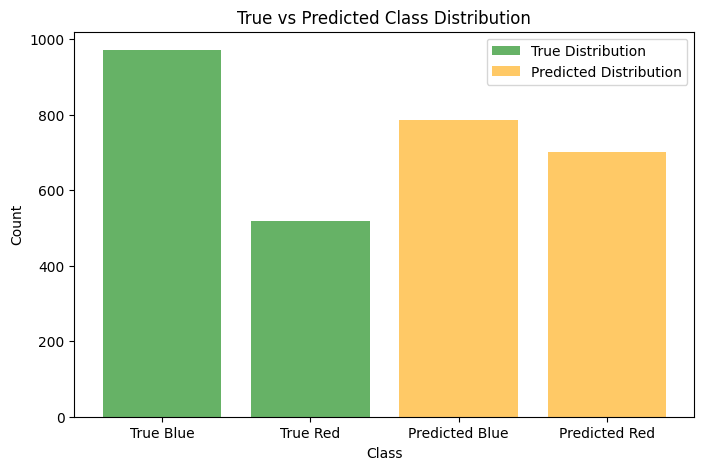

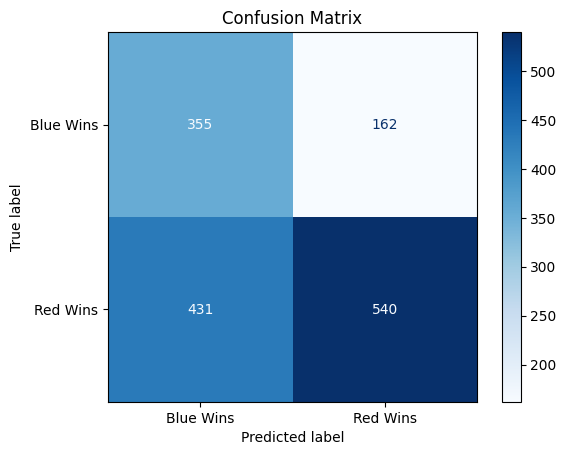


=== Classification Report ===
              precision    recall  f1-score   support

   Blue Wins       0.45      0.69      0.54       517
    Red Wins       0.77      0.56      0.65       971

    accuracy                           0.60      1488
   macro avg       0.61      0.62      0.60      1488
weighted avg       0.66      0.60      0.61      1488



In [68]:
# Predicted percentages
predicted_counts = pd.Series(y_test_pred).value_counts()
predicted_percentages = (predicted_counts / len(y_test_pred)) * 100
print("\n=== Predicted Class Distribution ===")
print(f"Blue Wins: {predicted_percentages[0]:.2f}%")
print(f"Red Wins: {predicted_percentages[1]:.2f}%")

print("\n=== Predicted Class Distribution ===")
print(f"Blue Wins Predicted: {predicted_percentages[0]:.2f}%")
print(f"Red Wins Predicted: {predicted_percentages[1]:.2f}%")

# True class distribution
true_counts = pd.Series(y_test).value_counts()
true_percentages = true_counts / len(y_test) * 100

print("\n=== True Class Distribution ===")
print(f"Blue Wins: {true_percentages[0]:.2f}%")
print(f"Red Wins: {true_percentages[1]:.2f}%")

# Plot distributions
plt.figure(figsize=(8, 5))
plt.bar(["True Blue", "True Red"], true_counts, color="green", alpha=0.6, label="True Distribution")
plt.bar(["Predicted Blue", "Predicted Red"], predicted_counts, color="orange", alpha=0.6, label="Predicted Distribution")
plt.title("True vs Predicted Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend()
plt.show()

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Blue Wins", "Red Wins"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_test_pred, target_names=["Blue Wins", "Red Wins"]))

In [69]:
# Save the main model
import joblib

# Ensure the main model is trained
joblib.dump(clf, "../models/deth_5_test_new.pkl")
print("Main model saved as 'deth_5_test_new.pkl'")


Main model saved as 'deth_7_test_new.pkl'
